In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append('..')
from utils.metrics import AndersonDarlingDistance, KendallDependenceMetric

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
'''
Load Dataset
'''
data = pd.read_csv('../data_train_log_return.csv', header=None).drop(columns=[0])
scaler = MinMaxScaler().fit(data.values)
X_train = torch.Tensor(scaler.transform(data.values)).to(device)
# X_train = torch.Tensor(data.values).to(device)

'''
Load Metrics
'''
ad = AndersonDarlingDistance()
kd = KendallDependenceMetric()

def compute_metrics(batch):
    size = batch.size(0)
    device_ = batch.device
    _,x = model.sample(size,device_)
    anderson = ad(batch.clone().detach(), x.clone().detach())
    kendall  = kd(batch.clone().detach(), x.clone().detach())
    return anderson, kendall

def visual_3D(data):
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    color = data[:,3]  # 4th dimension
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(x, y, z, c=color, cmap='viridis')
    
    plt.colorbar(scatter)
    ax.set_xlabel('1st Dimension')
    ax.set_ylabel('2nd Dimension')
    ax.set_zlabel('3rd Dimension')
    plt.show()

## Warsserstein GAN

In [5]:
'''
Model
'''
class W_Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(W_Generator, self).__init__()
        w = 8
        self.fc = nn.Sequential(
            nn.Linear(input_dim, w),
            nn.ReLU(),
            nn.Linear(w, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

class W_Critic(nn.Module):
    def __init__(self, input_dim):
        super(W_Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(0),
            nn.Linear(64, 32),
            nn.ReLU(0),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.fc(x)

# Parameters
latent_dim = 64  # latent dim
data_dim = 4    # data dimension
lr = 0.0001     # learn rate

# initialize
generator = W_Generator(latent_dim, data_dim).to(device)
critic = W_Critic(data_dim).to(device)

# BCE Loss and optimizer
critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

'''
Training
'''
epochs = 2500
batch_size = 512
clip_value = 0.015

for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):

        real_data = torch.Tensor(X_train[i:min(i+batch_size, len(X_train))]).to(device)
        critic_optimizer.zero_grad()
        critic_real = critic(real_data)
        
        fake_data = generator(torch.randn(len(real_data), latent_dim).to(device))
        critic_fake = critic(fake_data)
        
        critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake)
        critic_loss.backward()
        critic_optimizer.step()

        # Weight Clipping
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        g_optimizer.zero_grad()
        gen_data = generator(torch.randn(len(real_data), latent_dim).to(device))
        g_loss = -torch.mean(critic(gen_data))
        g_loss.backward()
        g_optimizer.step()

    # Progress
    if (epoch+1) % 400 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {critic_loss.item():.4f}, Generator Loss: {g_loss.item():.4f} \n\
              Anderson Darling Distance: {float(ad.forward(real_data, fake_data)):.4f} Kendall Dependence: {float(kd.forward(real_data, fake_data)):.4f}")

torch.save(generator.state_dict(), 'WGAN_Generator.pt')


/Data/.sys/envs/env0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                       | 0/2500 [00:00<?, ?it/s]/Data/.sys/envs/env0/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|                              | 10/2500 [00:00<01:04, 38.87it/s]

Epoch 1/2500, Critic Loss: -0.0000, Generator Loss: 0.0166 
              Anderson Darling Distance: 690.2466 Kendall Dependence: 2.0201


 17%|████▊                        | 418/2500 [00:04<00:20, 99.51it/s]

Epoch 400/2500, Critic Loss: -0.0084, Generator Loss: 0.0223 
              Anderson Darling Distance: 343.5150 Kendall Dependence: 2.0630


 33%|█████████                   | 814/2500 [00:08<00:16, 101.59it/s]

Epoch 800/2500, Critic Loss: -0.0036, Generator Loss: 0.0191 
              Anderson Darling Distance: 70.8026 Kendall Dependence: 2.0607


 49%|█████████████▋              | 1220/2500 [00:12<00:13, 98.03it/s]

Epoch 1200/2500, Critic Loss: -0.0007, Generator Loss: 0.0163 
              Anderson Darling Distance: 7.5629 Kendall Dependence: 2.0112


 64%|█████████████████▍         | 1611/2500 [00:16<00:08, 102.38it/s]

Epoch 1600/2500, Critic Loss: -0.0003, Generator Loss: 0.0199 
              Anderson Darling Distance: 4.1627 Kendall Dependence: 1.9727


 81%|█████████████████████▊     | 2018/2500 [00:20<00:04, 102.76it/s]

Epoch 2000/2500, Critic Loss: -0.0001, Generator Loss: 0.0192 
              Anderson Darling Distance: 5.0129 Kendall Dependence: 1.9543


 97%|██████████████████████████ | 2414/2500 [00:24<00:00, 102.78it/s]

Epoch 2400/2500, Critic Loss: -0.0004, Generator Loss: 0.0185 
              Anderson Darling Distance: 7.0749 Kendall Dependence: 1.9414


100%|████████████████████████████| 2500/2500 [00:25<00:00, 99.76it/s]


100%|█████████████████████████████| 100/100 [00:00<00:00, 141.01it/s]


Mean Anderson Darling Distance: 12.9074         
 Mean Kendall Dependence: 2.0017


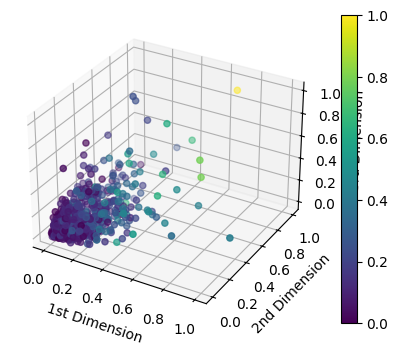

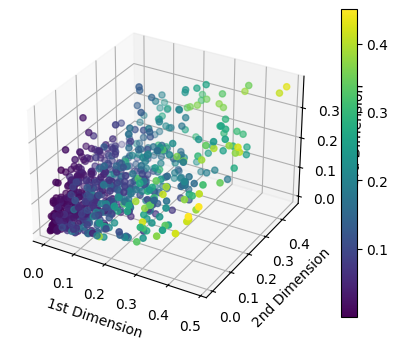

In [6]:
'''
Evaluation
'''
# from torchinfo import summary
# print(summary(generator, input_size=(1,4), device=device))
# print(summary(critic, input_size=(1,4)), device=device)

# Sampling
ads = []
kds = []

for i in tqdm(range(100)):
    with torch.no_grad():
        sample = generator(torch.randn(len(X_train), latent_dim).to(device))
    ads.append(float(ad.forward(X_train, sample)))
    kds.append(float(kd.forward(X_train, sample)))

print(f'Mean Anderson Darling Distance: {np.mean(ads):.4f} \
        \n Mean Kendall Dependence: {np.mean(kds):.4f}')

visual_3D(X_train.cpu().detach().numpy())
visual_3D(sample.cpu().numpy())

In [8]:
'''
Inference
'''
! /Data/.sys/envs/env0/bin/python WGAN_inference.py